In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
file_path = "..\\..\\Datasets\\Data.xlsx"
data_title = "data_Flex_raw_data"

columns_data = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'N/A_1', 'N/A_2', 'angle', 'time', 'session']
columns_features_considered = columns_data[:8]
column_ground_truth = columns_data[10]
# Note that we ignore the 'time' column. That makes our data slightly imprecise as there are tiny, 
# TINY differences in time intervals in the real data (not worth modeling). Each timestep represents 
# 1 millisecond, 0.001 second. 

# TODO: Change index columns to seconds instead of milliseconds. Perhaps lambda round all time measurements, then use 
# as the index? Or just give a range(0, len(array) * 0.001, 0.001)

In [3]:
# Read first sheet (table of contents), find index of entry with correct title, then load the corresponding excel sheet
table_of_contents = pd.read_excel(file_path, sheet_name=0, header=None)
sheet_index = table_of_contents[table_of_contents[0] == data_title][0].index[0]
sheet_data = pd.read_excel(file_path, sheet_name=sheet_index + 1, header=None)
sheet_data.columns = columns_data

In [4]:
features = sheet_data[columns_features_considered]
# features.index = sheet_data['time'] 
# If I index time, then we have floats as indexes. One row already represents one time point

ground_truth = pd.DataFrame(sheet_data[column_ground_truth])
#ground_truth.index = sheet_data['time']

#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std
# SEEMS UNECESSARY, AS WE NORMALIZE ON THE SENSOR
# HOW MUCH DIFFERENCE IS THERE?

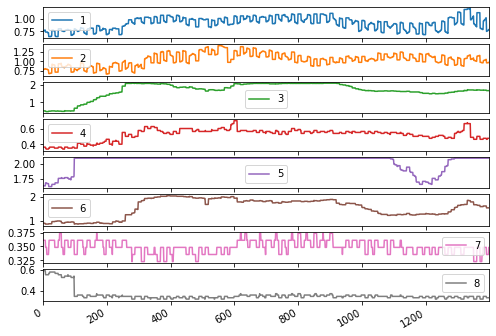

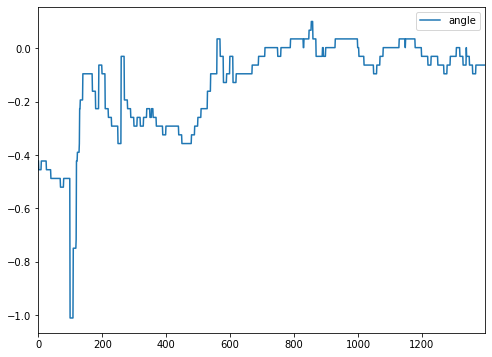

In [5]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
features.plot(subplots=True)

ground_truth.plot()

In [6]:
def multivariate_data(dataset_features, dataset_ground_truth, start_index, end_index, history_size,
                      target_size, step, single_step=False, print_index=False):
  data, labels, history = [], [], []

  start_index = start_index + history_size 
  # such that we always have history_size (100) observations to base our predictions on
  if end_index is None:
    end_index = len(dataset) - target_size 
    # such that we never predict based on the last future_target (10) measurements

  if print_index: print("start")
  for i in range(start_index, end_index): # start 100, end 790. 
      # TODO: It actually goes to 800 (when end_index is not None), meaning that our last 10 predictions cannot be verified with our training set. This is a problem
    if print_index: print("A", i,)
    indices = range(i-history_size, i, step) # range(0, 100) step size of 1          --- our sliding window
    data.append(dataset_features[indices]) # append new array that contains all values within our sliding window
    # TODO: ONE PROBLEM KINDA? Step size makes no sense. Doesn't feel like there's any point to it. 
    history.append(dataset_ground_truth[indices])

    if single_step:
      labels.append(dataset_ground_truth[i+target_size])
    else:
      labels.append(dataset_ground_truth[i:i+target_size])

  return np.array(data), np.array(labels), np.array(history)

In [55]:
STEP = 1
past_history = 100
future_target = 10            # setting this to 0 would make sense
# Aggregates STEP predictions, looks at a total of PASTHISTORY observations, 
# predicts the observation at FUTURETARGET observations in the future
TRAIN_SPLIT = 800

dataset = features.values
ground_truth2 = ground_truth.values

In [56]:
x_train, y_train, _ = multivariate_data(dataset, ground_truth2, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False, print_index = False)

print ('Single window of past history : {}'.format(x_train[0].shape))
print(len(x_train), len(y_train))
print(x_train.shape)

Single window of past history : (100, 8)
700 700
(700, 100, 8)


In [57]:
x_val, y_val, y_history = multivariate_data(dataset, ground_truth2, TRAIN_SPLIT, 
                                               None, past_history,
                                               future_target, STEP,
                                               single_step=False, print_index = False)

In [58]:
#### TODO: Need to understand why this is necessary. It does some magic. Somehow I need my data to be of form BatchDataset
# Here we apply batching and shuffling. But WHY? 

BATCH_SIZE = 1
#BUFFER_SIZE = 100

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
train_data = train_data.batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
val_data = val_data.batch(BATCH_SIZE)
val_data_history = tf.data.Dataset.from_tensor_slices((x_val, y_val, y_history)).repeat().batch(BATCH_SIZE)

#train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#val_data = val_data.batch(BATCH_SIZE).repeat()

In [59]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.LSTM(32, batch_input_shape=(BATCH_SIZE, x_train.shape[1], x_train.shape[2]), return_sequences = False)) # input_shape=x_train.shape[-2:]
model.add(tf.keras.layers.LSTM(32, input_shape=x_train.shape[-2:], return_sequences = False))
model.add(tf.keras.layers.Dense(future_target))

#model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 5,578
Trainable params: 5,578
Non-trainable params: 0
_________________________________________________________________


In [60]:
EPOCHS = 5
EVALUATION_INTERVAL = int(len(x_train) / BATCH_SIZE)
VAL_STEPS = int(len(x_val) / BATCH_SIZE)

history = model.fit(train_data, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_data,
                    validation_steps=VAL_STEPS
                    )

Train for 700 steps, validate for 488 steps
Epoch 1/5
700/700 [==============================] - 10s 14ms/step - loss: 0.0324 - categorical_accuracy: 0.1271 - val_loss: 0.0537 - val_categorical_accuracy: 0.0225
Epoch 2/5
700/700 [==============================] - 8s 11ms/step - loss: 0.0334 - categorical_accuracy: 0.1257 - val_loss: 0.0516 - val_categorical_accuracy: 0.0225
Epoch 3/5
700/700 [==============================] - 8s 12ms/step - loss: 0.0332 - categorical_accuracy: 0.1543 - val_loss: 0.0513 - val_categorical_accuracy: 0.0328
Epoch 4/5
700/700 [==============================] - 8s 11ms/step - loss: 0.0335 - categorical_accuracy: 0.1686 - val_loss: 0.0514 - val_categorical_accuracy: 0.0225
Epoch 5/5
700/700 [==============================] - 8s 11ms/step - loss: 0.0332 - categorical_accuracy: 0.1614 - val_loss: 0.0457 - val_categorical_accuracy: 0.0307


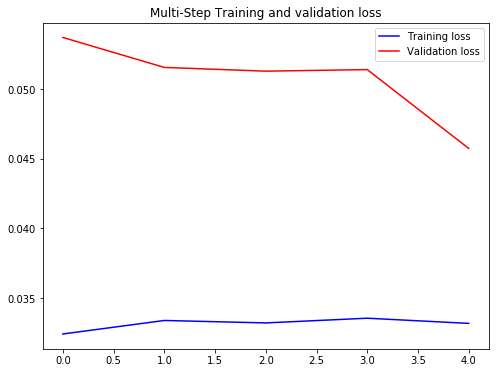

In [61]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

<BatchDataset shapes: ((None, 100, 8), (None, 10, 1)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 100, 8), (None, 10, 1), (None, 100, 1)), types: (tf.float64, tf.float64, tf.float64)>
1 [0.03465841 0.03046965 0.03515929 0.03309938 0.03769327 0.03316495
 0.0230478  0.03136426 0.0303603  0.02546313]


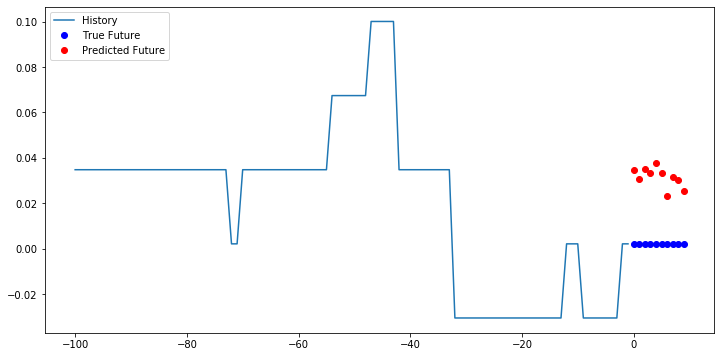

100 [0.00672322 0.0034789  0.00729995 0.01158454 0.00616195 0.02540393
 0.01162782 0.04013085 0.0487459  0.02712653]


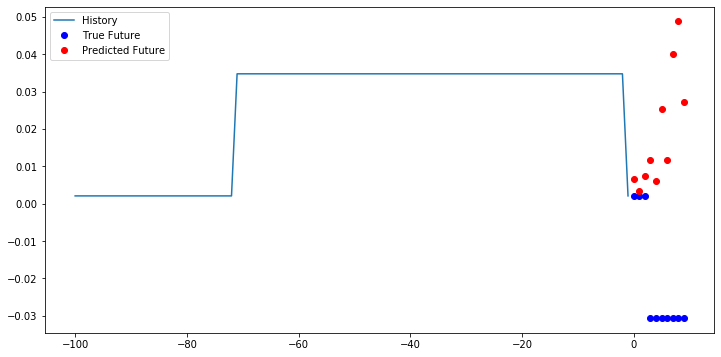

200 [-0.00562718 -0.01432535 -0.00510375  0.01178365 -0.00328148  0.00254858
  0.01416138  0.04679988  0.07081836  0.02418771]


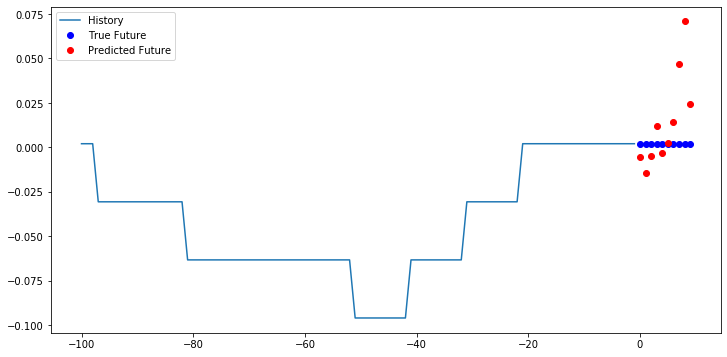

300 [0.01729953 0.00462931 0.01173996 0.01464136 0.00893923 0.02479827
 0.01098548 0.03514301 0.04463711 0.02005699]


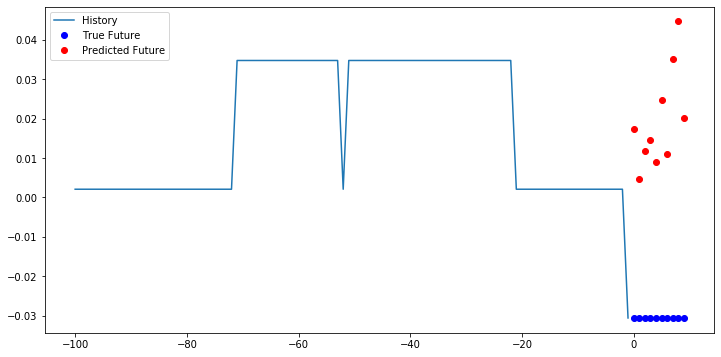

400 [ 0.00366722 -0.00571601  0.00418227  0.0101772   0.00492909  0.01900911
  0.00859035  0.04695724  0.05193974  0.02612075]


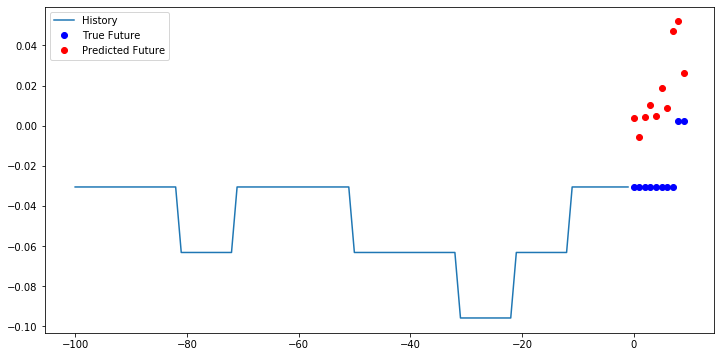

500 [0.03025707 0.02902544 0.03036543 0.03626404 0.03584553 0.02798299
 0.02567187 0.02741293 0.03524066 0.02620403]


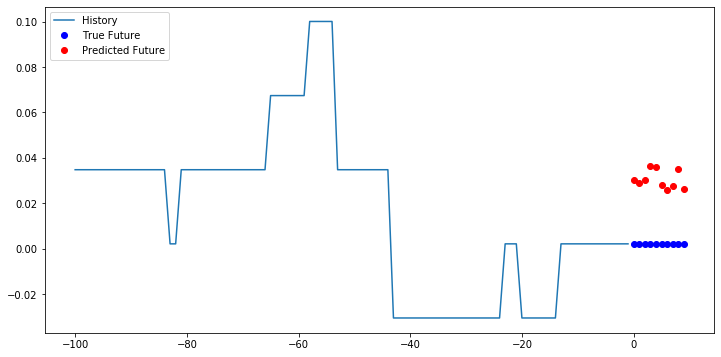

In [62]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

# TODO: This ought to be test_data
#for x, y in val_data.take(3):
#  multi_step_plot(x[0], y[0], model.predict(x)[0])

# print(val_data[50])

# print(len(val_data))

#iterator = iter(val_data)
#elem = next(iterator)
#print(elem[1])

print(val_data)
print(val_data_history)

# History should be the old angle measurements (that aren't used for training)
for num in [1, 100, 200, 300, 400, 500]:
    for index, elem in enumerate(val_data_history):
        if index == num:
            # print(index, elem[2][0]) # print index and y value
            print(index, model.predict(elem[0])[0])
            multi_step_plot(elem[2][0], elem[1][0], model.predict(elem[0])[0])
            break

# TODO: Show entire history in one plot, then show some instances of sliding window predictions on that plot
# instead of only being able to show the sliding windows as separate plots 
# Probably add time index to accomplish this <--

# Todo: perhaps add a time dimension back as index. Because otherwise if you use STEP-size, then it won't know that it
# skipped some time (20 measurements means 20 timesteps, instead of the 100 truncated time steps)

# Todo: use separate test-data instead of using validation data for testing